In [8]:
from pathlib import Path
import tvm
from tvm.contrib import graph_executor as runtime
from tvm import relay, transform
import onnx
import imageio
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
model_file = Path.cwd().parent / 'models' / 'yunet' / 'yunet.onnx'
if not model_file.exists():
    logging.error(f'Model file {model_file} not found')

In [3]:
onnx_model = onnx.load(model_file)
onnx_model.graph.input

[name: "input"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "batch_size"
      }
      dim {
        dim_value: 3
      }
      dim {
        dim_param: "height"
      }
      dim {
        dim_param: "width"
      }
    }
  }
}
]

In [4]:
target = "llvm"
input_tensor = "input"
shape_dict = {input_tensor: (1, 3, 320, 240)}
mod, params = relay.frontend.from_onnx(onnx_model, shape_dict)

target = "llvm"
with transform.PassContext(opt_level=3):
    lib=relay.build(mod, target, params=params)

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


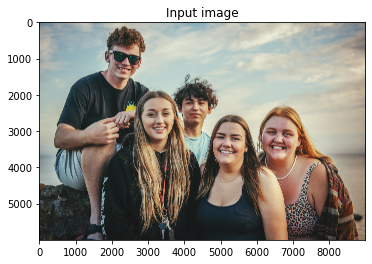

In [21]:
assets_dir = Path.cwd().parent / "assets"
original_image = imageio.imread(assets_dir / "multiple_faces_image.jpg")
plt.imshow(original_image)
plt.title("Input image")
plt.show()

In [22]:
image = cv2.resize(original_image, (320, 240))
image = np.transpose(image, [2, 0, 1])
image = np.expand_dims(image, axis=0)
image = image.astype(np.float32)

In [23]:
from itertools import product
from typing import List, Tuple

class PriorBox(object):
    def __init__(self,
                 input_shape: Tuple[int] = (320, 240), # [in_w, in_h]
                 output_shape: Tuple[int] = (320, 240), # [img_w, img_h]
                 variance: List[float] = [0.1, 0.2]) -> None:
        super(PriorBox, self).__init__()

        self.min_sizes = [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]]
        self.steps = [8, 16, 32, 64]

        self.in_w, self.in_h = input_shape
        self.out_w, self.out_h = output_shape
        self.variance = variance

        for ii in range(4):
            if(self.steps[ii] != pow(2,(ii+3))):
                print("steps must be [8,16,32,64]")
                sys.exit()

        self.feature_map_2th = [int(int((self.in_h + 1) / 2) / 2),
                                int(int((self.in_w + 1) / 2) / 2)]
        self.feature_map_3th = [int(self.feature_map_2th[0] / 2),
                                int(self.feature_map_2th[1] / 2)]
        self.feature_map_4th = [int(self.feature_map_3th[0] / 2),
                                int(self.feature_map_3th[1] / 2)]
        self.feature_map_5th = [int(self.feature_map_4th[0] / 2),
                                int(self.feature_map_4th[1] / 2)]
        self.feature_map_6th = [int(self.feature_map_5th[0] / 2),
                                int(self.feature_map_5th[1] / 2)]

        self.feature_maps = [self.feature_map_3th, self.feature_map_4th,
                             self.feature_map_5th, self.feature_map_6th]

        self.priors = self.generate_priors()

    def generate_priors(self) -> np.ndarray:
        anchors = np.empty(shape=[0, 4])
        for k, f in enumerate(self.feature_maps):
            min_sizes = self.min_sizes[k]
            for i, j in product(range(f[0]), range(f[1])): # i->in_h, j->in_w
                for min_size in min_sizes:
                    s_kx = min_size / self.in_w
                    s_ky = min_size / self.in_h

                    cx = (j + 0.5) * self.steps[k] / self.in_w
                    cy = (i + 0.5) * self.steps[k] / self.in_h

                    anchors = np.vstack(
                        (anchors, np.array([cx, cy, s_kx, s_ky]))
                    )
        return anchors

    def decode(self, loc: np.ndarray, conf: np.ndarray, iou: np.ndarray, ignore_score: float = 0.6) -> np.ndarray:
        '''Decodes the locations (x1, y1, x2, y2) and scores (c) from the priors, and the given loc and conf.
        Ignore low scores based on ignore_score.
        Args:
            loc (np.ndarray): loc produced from loc layers of shape [num_priors, 4]. '4' for [x_c, y_c, w, h].
            conf (np.ndarray): conf produced from conf layers of shape [num_priors, 2]. '2' for [p_non_face, p_face].
            iou (np.ndarray): iou produced from iou layers of shape [num_priors, 1]. '1' for [iou].
            ignore_score (float): used to filter out low score instances.
        Return:
            dets (np.ndarray): dets is concatenated by bboxes, landmarks and scores. 
                bboxes consists of num_priors * (x1, y1, x2, y2) of shape [num_priors, 4].
                landmarks consists of num_priors * (x_le, y_le, x_re, y_r2, x_n, y_n, x_ml, y_ml, x_mr, y_mr) of shape [num_priors, 5*2].
        '''
        # get score
        cls_scores = conf[:, 1]
        iou_scores = iou[:, 0]
        # clamp
        _idx = np.where(iou_scores < 0.)
        iou_scores[_idx] = 0.
        _idx = np.where(iou_scores > 1.)
        iou_scores[_idx] = 1.
        scores = np.sqrt(cls_scores * iou_scores)
        scores = scores[:, np.newaxis]

        # ignore low scores
        idx = np.where(scores[:, 0] > ignore_score)[0]
        scores = scores[idx]
        loc = loc[idx]
        priors = self.priors[idx]

        # get bboxes
        bboxes = np.hstack((
            priors[:, 0:2]+loc[:, 0:2]*self.variance[0]*priors[:, 2:4],
            priors[:, 2:4]*np.exp(loc[:, 2:4]*self.variance)
        ))
        # (x_c, y_c, w, h) -> (x1, y1, w, h)
        bboxes[:, 0:2] -= bboxes[:, 2:4] / 2
        # scale recover
        bbox_scale = np.array([self.out_w, self.out_h]*2)
        bboxes = bboxes * bbox_scale

        # get landmarks
        landmarks = np.hstack((
            priors[:, 0:2]+loc[:,  4: 6]*self.variance[0]*priors[:, 2:4],
            priors[:, 0:2]+loc[:,  6: 8]*self.variance[0]*priors[:, 2:4],
            priors[:, 0:2]+loc[:,  8:10]*self.variance[0]*priors[:, 2:4],
            priors[:, 0:2]+loc[:, 10:12]*self.variance[0]*priors[:, 2:4],
            priors[:, 0:2]+loc[:, 12:14]*self.variance[0]*priors[:, 2:4]
        ))
        # scale recover
        landmark_scale = np.array([self.out_w, self.out_h]*5)
        landmarks = landmarks * landmark_scale

        dets = np.hstack((bboxes, landmarks, scores))
        return dets

In [24]:
module = runtime.GraphModule(lib["default"](tvm.cpu()))
module.set_input(input_tensor, tvm.nd.array(image))
module.run()
loc = module.get_output(0).numpy()
conf = module.get_output(1).numpy()
iou = module.get_output(2).numpy()

print(conf.shape)
print(loc.shape)
print(iou.shape)

(4385, 2)
(4385, 14)
(4385, 1)


In [25]:
pb = PriorBox()
print(pb.generate_priors().shape)
dets = pb.decode(loc, conf, iou)
print(dets)
print(dets.shape)

(4385, 4)
[]
(0, 15)
